In [1]:
import sys
import numpy as np
import pandas as pd
# from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

from siamese import get_pairwise_batch, make_oneshot_task, test_oneshot

import numpy.random as rng

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle

train_in = open("mini-imagenet-cache-train.pkl", "rb")

train = pickle.load(train_in)


# print(test['class_dict'].keys())
# print(test['class_dict'])
ungrouped_Xtrain = train["image_data"]

train_data = ungrouped_Xtrain.reshape([64, 600, 84, 84, 3])

In [17]:
val_in = open("mini-imagenet-cache-val.pkl", "rb")

val = pickle.load(val_in)


# print(test['class_dict'].keys())
# print(test['class_dict'])
ungrouped_Xval = val["image_data"]

val_data = ungrouped_Xval.reshape([16, 600, 84, 84, 3])

### Loading the validation images into tensors

### Saving the validation tensors on disk

In [6]:
# del X, y ,c ,Xval, yval, cval

ERROR! Session/line number was not unique in database. History logging moved to new session 113


In [4]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [5]:
def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [6]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [14]:
model = get_siamese_model((84, 84, 3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         10648896    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]         

In [15]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading the train tensors

In [29]:
# Hyper parameters
evaluate_every = 5 # interval for evaluating on one-shot tasks\
download_every = 0
batch_size = 32
n_iter = 10 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks. has to be less than num classes in dataset
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [10]:
model_path = './weights/'

In [30]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_pairwise_batch(batch_size, train_data)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True, test_data=val_data)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 5 iterations: 0.06616146961847941 mins
Train Loss: 0.937522828578949
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 17.6% 10 way one-shot learning accuracy 

Current best: 17.6, previous best: -1

 ------------- 

Time for 10 iterations: 0.3344926118850708 mins
Train Loss: 0.9164236783981323
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 14.4% 10 way one-shot learning accuracy 



### Load model weights

In [16]:
# model.load_weights(os.path.join(model_path, "weights.20000.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [17]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [18]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [19]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [35]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 96.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  62.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average

### Save the accuracies on disk

In [36]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [20]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [21]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [22]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

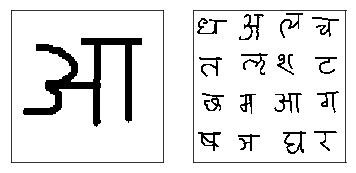

In [40]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

### Resuts

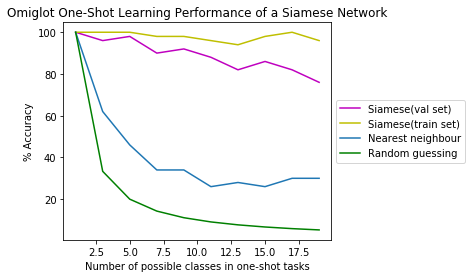

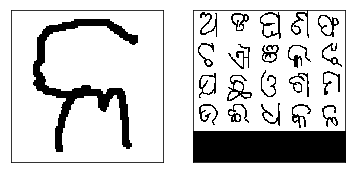

In [41]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)